In [1]:
!pip install datasets diffusers transformers accelerate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# 1. Load Dataset
print("Memuatdataset...")
raw_dataset= load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untukproses adaptasi teks
all_captions= [item['text'] for item in raw_dataset]


Memuatdataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [2]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
max_tokens=max_tokens,
output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])


Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [3]:
def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0  # Normalisasi0-1
    # Proses Teks
    caption = item['text']
    return caption, image
# Membuatgenerator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)
# Membuattf.data.Dataset
train_ds= tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)
# Batching dan TransformasiTeks keAngka
train_ds= train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds= \
train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)


In [4]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer= transformer
        self.vqvae_encoder= vqvae_encoder
        self.loss_tracker= keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # 1. Ubahgambaraslimenjaditoken visual menggunakanencoder
        # Kita simulasikandenganoutput dummy sesuaiukuranlatent grid (misal16x16)
        visual_tokens= tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

        # 2. Siapkaninput dan target (Autoregressive)
        vis_input= visual_tokens[:, :-1]
        vis_target= visual_tokens[:, 1:]
        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # HitungLoss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [19]:
# Definisi dummy VQVAE Encoder
def build_vqvae_encoder():
    input_shape = (64, 64, 3)
    inputs = keras.Input(shape=input_shape)
    # PokemonTrainer's train_step simulates visual_tokens of shape (batch_size, 256)
    # with values between 0 and 1023 (1024 distinct tokens).
    outputs = layers.Lambda(lambda x: tf.random.uniform(
        (tf.shape(x)[0], 256), minval=0, maxval=1024, dtype=tf.int32
    ), name="dummy_visual_token_output")(inputs)
    return keras.Model(inputs, outputs, name="vqvae_encoder_dummy")

vqvae_encoder = build_vqvae_encoder()
print("Dummy VQVAE Encoder dibuat.")

# Definisi dummy Transformer Model
def build_transformer_model(text_vocab_size, visual_token_vocab_size, seq_len_text, seq_len_visual):
    embedding_dim = 128 # Contoh dimensi embedding

    # Input untuk token teks dan token visual
    text_input = keras.Input(shape=(seq_len_text,), dtype=tf.int32, name="text_input") # (batch_size, 20)
    visual_input = keras.Input(shape=(seq_len_visual,), dtype=tf.int32, name="visual_input") # (batch_size, 255)

    # Embeddings untuk teks dan token visual
    text_embeddings = layers.Embedding(text_vocab_size, embedding_dim)(text_input) # (batch_size, 20, embedding_dim)
    visual_embeddings = layers.Embedding(visual_token_vocab_size, embedding_dim)(visual_input) # (batch_size, 255, embedding_dim)

    # Buat 'konteks' sederhana dari embedding teks
    # Untuk transformer sungguhan, ini akan lebih kompleks (misalnya, cross-attention)
    text_context_vector = layers.GlobalAveragePooling1D()(text_embeddings) # (batch_size, embedding_dim)

    # Ulangi konteks teks untuk setiap posisi token visual
    text_context_expanded = layers.RepeatVector(seq_len_visual)(text_context_vector) # (batch_size, 255, embedding_dim)

    # Gabungkan konteks teks dengan embedding visual
    combined_features = layers.Concatenate(axis=-1)([visual_embeddings, text_context_expanded]) # (batch_size, 255, 2*embedding_dim)

    # Terapkan layer TimeDistributed Dense untuk memprediksi token visual berikutnya untuk setiap posisi
    # Output harus berbentuk (batch_size, seq_len_visual, visual_token_vocab_size)
    output_logits = layers.TimeDistributed(layers.Dense(visual_token_vocab_size))(combined_features)

    return keras.Model(inputs=[text_input, visual_input], outputs=output_logits, name="transformer_dummy")

# Parameter untuk dummy transformer
# text_vocab_size: len(vocab) dari text_vectorizer
# visual_token_vocab_size: 1024 (dari maxval di dummy visual_tokens)
# seq_len_text: seq_len (20) dari text_vectorizer
# seq_len_visual: 255 (dari visual_tokens[:, :-1])

transformer_model = build_transformer_model(
    text_vocab_size=len(vocab),
    visual_token_vocab_size=1024,
    seq_len_text=seq_len,
    seq_len_visual=255
)
print("Dummy Transformer Model dibuat.")


Dummy VQVAE Encoder dibuat.
Dummy Transformer Model dibuat.


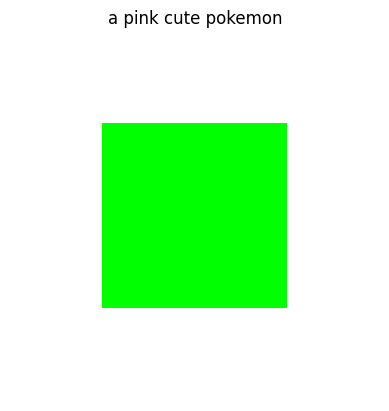

In [21]:
def generate_pokemon(prompt):
    # 1. Ubahtekskeangka
    tokenized_text= text_vectorizer([prompt])
    # 2. Generate token visual (Autoregressive)
    # Gunakanfungsigenerate_image_tokensyang kitabuatsebelumnya
    gen_vis_tokens= generate_image_tokens(transformer_model, tokenized_text, 256, 1024)
    # 3. Decode jadiGambar menggunakanPre-trained VAE
    # Gunakanfungsidecode_to_real_imageyang memanggilAutoencoderKL
    final_image= decode_to_real_image(gen_vis_tokens)
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()
# TEST
generate_pokemon("a pink cute pokemon")